# Sentiment Analysis Using the IMDB movie reviews and BERT transformer

> This notebook is just to illustrate how to use hugging face BERT transformer for sentiment classification problem, it doesn't aim for high accuracy and was not used in any competitions.

### Import data from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/dataset/IMDB.csv')
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:ylabel='sentiment'>

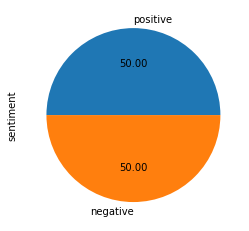

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the data to see if balanced
df['sentiment'].value_counts().plot.pie(autopct='%.2f')

### Text preprocessing

> Large language models such as BERT don't need text preprocessing as they are trained on large datasets that contains stop words and various words that is removed during preprocessing. However, we will preprocess the data and keep a copy of preprocessed data in case we wanted to try a different model and compare results. BERT only needs tokenized input and we will use BERT tokenizer for that purpose.

In [14]:
# install hugging face transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.5 MB/s eta 0:00:00


In [30]:
# make all imports needed for preprocessing
import transformers
import nltk

#### Lowercasing

In [57]:
df_copy = df.copy()
df_copy['review'] = df_copy['review'].str.lower()
df_copy.head(3)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive


#### Removing punctuations

> for this step we need tokenized sentences in order to find and remove punctuations, so we tokenize first

In [58]:
def rm_punkt(text):
    tokzr = nltk.tokenize.RegexpTokenizer(r"\w+")
    return tokzr.tokenize(''.join(text))

df_copy['review'] = df_copy['review'].apply(rm_punkt)
df_copy.head(5)

,review,sentiment
0,"[one, of, the, other, reviewers, has, mentione...",positive
1,"[a, wonderful, little, production, br, br, the...",positive
2,"[i, thought, this, was, a, wonderful, way, to,...",positive
3,"[basically, there, s, a, family, where, a, lit...",negative
4,"[petter, mattei, s, love, in, the, time, of, m...",positive


#### Removing stopwords

In [59]:
# Use nltk english stopwords to detect stopwords
nltk.download('stopwords')
stops = nltk.corpus.stopwords.words('english')
stops.append("br")

df_copy['review'] = df_copy['review'].apply(lambda x: [token for token in x if token not in stops])
df_copy.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment
0,"[one, reviewers, mentioned, watching, 1, oz, e...",positive
1,"[wonderful, little, production, filming, techn...",positive
2,"[thought, wonderful, way, spend, time, hot, su...",positive
3,"[basically, family, little, boy, jake, thinks,...",negative
4,"[petter, mattei, love, time, money, visually, ...",positive


#### Lemmatization

In [ ]:
# Using WordnetLemmatizer object from nltk.stem
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

wordnet = nltk.stem.WordNetLemmatizer()

def lemmatization(text):
    result=[]
    for token,tag in nltk.pos_tag(text):
        # take first character from pos_tag and lowers it to pos of lemmatizer
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'  
        result.append(wordnet.lemmatize(token,pos))
    return result

df_copy['review']=df_copy['review'].apply(lemmatization)
df_copy.head(5)

In [61]:
# Save the preprocessed data to drive
df_copy.to_csv('/content/drive/MyDrive/dataset/IMDB_preprocessed.csv')

### Creating our model

In [18]:
# All needed imports
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertModel
import transformers

# Create Bert tokenizer and classes dictionary
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
classes = {'negative':0,
          'positive':1}

transformers.logging.set_verbosity_warning()

> Create Torch dataset object to be used by the model during training

In [19]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.y = [classes[label] for label in df['sentiment']]
        self.x = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['review']]

    def classes(self):
        return self.y

    def __len__(self):
        return len(self.y)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.y[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.x[idx]

    def __getitem__(self, idx):
        batch_x = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

> Model Architecture which uses bert model then two layer FFNN with sigmoid activation on final layer

In [77]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.input = nn.Linear(768, 128)
        self.first = nn.Linear(128,32)
        self.dropout = nn.Dropout(dropout)
        self.second = nn.Linear(32,1)

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        input_output = self.input(pooled_output)
        first_output = F.relu(self.first(input_output))
        dropout_output = self.dropout(first_output)
        second_output = self.second(first_output)
        return torch.sigmoid(second_output)

> Training funciton

In [78]:
def get_data(train_data, val_data):
    return Dataset(train_data), Dataset(val_data)

def train(model, train_data, val_data, learning_rate, epochs, name, path, best=0):
    # Lists to hold train and validation accuracies
    train_acc = []
    val_acc = [] 

    # Put data in train loaders
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=8)

    # check if gpu is available
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Set loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)

    # if cude avaialable send model and loss to cuda
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    # track best accuracy for model checkpoint
    best_val_acc = best

    for epoch_num in range(epochs):
            # accuracies for this epoch
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader,desc='Epoch '+ str(epoch_num+1)):
                # Send all inputs to device
                train_label = train_label.to(device)
                train_input = train_input.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                # get model outputs
                output = model(input_id, mask)
                output = output.flatten()
                # calculate losses
                batch_loss = criterion(output, train_label.float())
                total_loss_train += batch_loss.item()
                
                # calculate accuracy
                acc = (torch.round(output) == train_label).sum().item()
                total_acc_train += acc

                # back prop
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            # stop back prop to start validation
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    output = output.flatten()
                    batch_loss = criterion(output, val_label.float())
                    total_loss_val += batch_loss.item()
                    
                    acc = (torch.round(output) == val_label).sum().item()
                    total_acc_val += acc

            # Save model based on validation accuracy       
            if total_acc_val > best_val_acc:
                checkpoint = {
                  'epoch': epoch_num + 1,
                  'state_dict': model.state_dict(),
                  'name': name,
                  'learning_rate': learning_rate
                }
                torch.save(checkpoint, path)  
                print(F'Validation accuracy imporved from  {best_val_acc} to {total_acc_val}')
                best_val_acc = total_acc_val       
            
            # Append accuracies and print epoch summary
            train_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
    return train_acc[epochs-1], val_acc[epochs-1], train_acc, val_acc

> Function uses validation data to get model specs when loaded

In [79]:
def validate(model, val_data):
    #empty lists for labels
    pred_labels =[]
    val_labels=[]
    # Create torch dataset instance for data
    val = Dataset(val_data)
    # Create dataloader
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)
    # check is gpu available
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_val = 0
    with torch.no_grad():

        for val_input, val_label in val_dataloader:

              val_label = val_label.to(device)
              mask = val_input['attention_mask'].to(device)
              input_id = val_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              output = output.flatten()
              acc = (torch.round(output) == val_label).sum().item()
              total_acc_val += acc
    
    val_acc = total_acc_val / len(val_data)
    

    return val_acc

> Testing function

In [106]:
def evaluate(model, test_data):
    # empty lists for lables
    pred_labels =[]
    test_labels=[]
    
    # create torch dataset for data
    test = Dataset(test_data)
    # load test data
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    # use cuda if available
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            # send inputs to cuda
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            # get model output
            output = model(input_id, mask)
            output = output.flatten()
            output = torch.round(output)
            # calculate accuracy
            acc = (output == test_label).sum().item()
            total_acc_test += acc

            for i in range(len(output)):
                pred_labels.append(output[i].cpu().numpy())
                test_labels.append(test_label[i].cpu().numpy())
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    return pred_labels, test_labels

> Function to load saved models

In [81]:
def load_model_data(model, path, val_data):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    lr =  checkpoint['learning_rate']
    name =  checkpoint['name']
    acc = validate(model, val_data)
    print(F'Model Name:  {name}         Learning Rate: {lr}       Validation accuracy:  {acc}')
    return acc

### Training

In [82]:
# Create data splits
# Train = 70% --> 0.7
# Validate = 10% --> 0.1
# Test = 20% --> 0.2
df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.7*len(df)), int(.8*len(df))])

In [83]:
# empty cache
import gc
torch.cuda.empty_cache()
gc.collect()

43942

<AxesSubplot:ylabel='sentiment'>

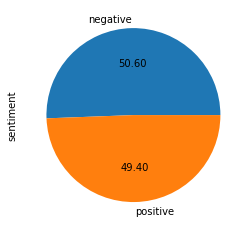

In [84]:
# Create samples to test functions before running model on full data
df_train_sample = df_train[0:500]
df_val_sample = df_validate[0:500]

df_train_sample['sentiment'].value_counts().plot.pie(autopct='%.2f')

> The following hyperparameters can be tuned. Four epochs are not enough but it is a good indicator on where the model is going. There is a BERT for sequence classification provided by hugging face but I preffered to use BERT and add my own linear layers.

In [87]:
# Set hyperparameters
EPOCHS = 4
LR = 1e-5
name = "IMDB_Sentiment_Analysis"
train_data, val_data = get_data(df_train, df_validate)
path = F'/content/drive/MyDrive/models/IMDBert.pt'

In [88]:
# train the model
model = BertClassifier()
tr, val, train_acc, val_acc = train(model, train_data, val_data, LR, EPOCHS, name, path)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch 1: 100%|██████████| 4375/4375 [51:55<00:00,  1.40it/s]


Validation accuracy imporved from  0 to 4655
Epochs: 1 | Train Loss:  0.030                 | Train Accuracy:  0.909                 | Val Loss:  0.023                 | Val Accuracy:  0.931


Epoch 2: 100%|██████████| 4375/4375 [51:58<00:00,  1.40it/s]


Validation accuracy imporved from  4655 to 4666
Epochs: 2 | Train Loss:  0.012                 | Train Accuracy:  0.969                 | Val Loss:  0.024                 | Val Accuracy:  0.933


Epoch 3: 100%|██████████| 4375/4375 [51:57<00:00,  1.40it/s]


Epochs: 3 | Train Loss:  0.005                 | Train Accuracy:  0.989                 | Val Loss:  0.027                 | Val Accuracy:  0.933


Epoch 4: 100%|██████████| 4375/4375 [51:56<00:00,  1.40it/s]


Epochs: 4 | Train Loss:  0.004                 | Train Accuracy:  0.992                 | Val Loss:  0.028                 | Val Accuracy:  0.930


> This model is close to overfitting this problem can be resolved by adding more linear layers and dropouts or by any other regularization method.

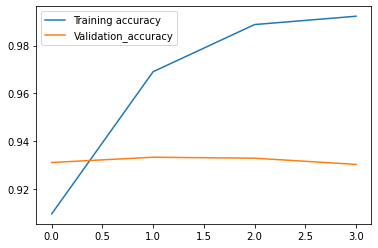

In [89]:
# plot training and validation accuracy over the epochs
plt.plot(range(EPOCHS), train_acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation_accuracy')
plt.legend()
plt.show()

### Testing

In [110]:
# load and evaluate model on test set
path = '/content/drive/MyDrive/models/IMDBert.pt'
model = BertClassifier()
load_model_data(model, path, df_validate)
pred_labels, test_labels = evaluate(model, df_test)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Name:  IMDB_Sentiment_Analysis         Learning Rate: 1e-05       Validation accuracy:  0.9332
Test Accuracy:  0.934


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5004
           1       0.93      0.93      0.93      4996

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Confusion Matrix:


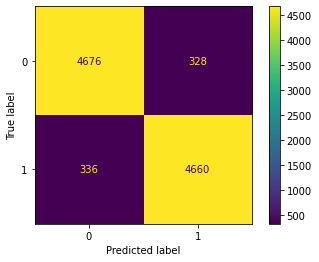

In [111]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Report model outputs
print('Classification Report:')
print(classification_report(test_labels, pred_labels))
print('Confusion Matrix:')
cm = ConfusionMatrixDisplay(confusion_matrix(test_labels, pred_labels))
cm.plot()
plt.show()